In [ ]:
!python -m pip install amazon-textract-caller --upgrade
!python -m pip install amazon-textract-response-parser --upgrade

In [3]:
import boto3
from IPython.display import Image, display
from trp import Document
from PIL import Image as PImage, ImageDraw
import time
from IPython.display import IFrame

In [4]:
# Curent AWS Region. Use this to choose corresponding S3 bucket with sample content

mySession = boto3.session.Session()
awsRegion = mySession.region_name

In [5]:
# S3 bucket that contains sample documents

# We are providing sample documents in this bucket so
# you do not have to manually download/upload test documents.

s3BucketName = "aws-workshops-" + awsRegion

In [6]:
# Amazon S3 client
s3 = boto3.client('s3')

# Amazon Textract client
textract = boto3.client('textract')

# 1. Detect text from local image

https://docs.aws.amazon.com/textract/latest/dg/API_DetectDocumentText.html

In [7]:
# Document
documentName = "simple-document-image.jpg"

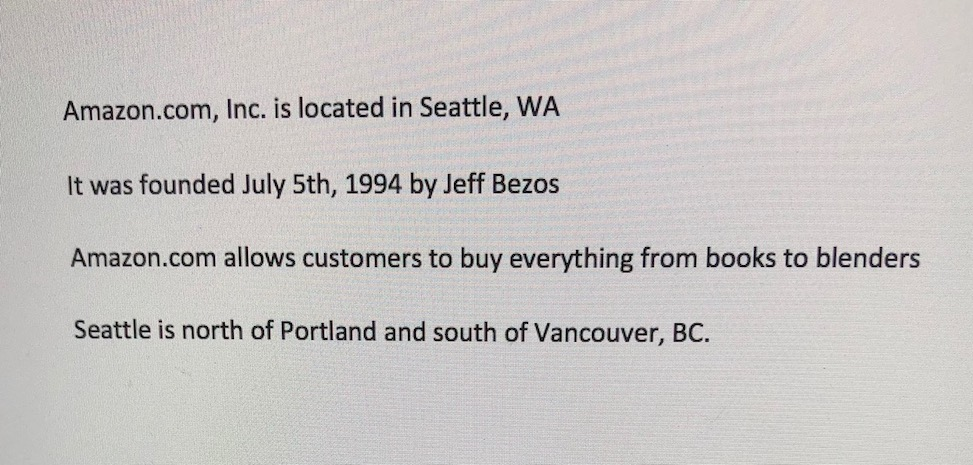

In [8]:
display(Image(filename=documentName))

In [9]:
# Read document content
with open(documentName, 'rb') as document:
    imageBytes = bytearray(document.read())

# Call Amazon Textract
response = textract.detect_document_text(Document={'Bytes': imageBytes})

# Print detected text
for item in response["Blocks"]:
    if item["BlockType"] == "LINE":
        print (item["Text"])

Amazon.com, Inc. is located in Seattle, WA
It was founded July 5th, 1994 by Jeff Bezos
Amazon.com allows customers to buy everything from books to blenders
Seattle is north of Portland and south of Vancouver, BC.


# 2. Detect text from S3 object

https://docs.aws.amazon.com/textract/latest/dg/API_DetectDocumentText.html

In [10]:
# Document
documentName = "textract-samples/simple-document-image.jpg"

In [11]:
display(Image(url=s3.generate_presigned_url('get_object', Params={'Bucket': s3BucketName, 'Key': documentName})))

In [12]:
# Call Amazon Textract
response = textract.detect_document_text(
    Document={
        'S3Object': {
            'Bucket': s3BucketName,
            'Name': documentName
        }
    })


# Print detected text
for item in response["Blocks"]:
    if item["BlockType"] == "LINE":
        print (item["Text"])

Amazon.com, Inc. is located in Seattle, WA
It was founded July 5th, 1994 by Jeff Bezos
Amazon.com allows customers to buy everything from books to blenders
Seattle is north of Portland and south of Vancouver, BC.


## Lines and Words of Text - JSON Structure

https://docs.aws.amazon.com/textract/latest/dg/API_BoundingBox.html

https://docs.aws.amazon.com/textract/latest/dg/text-location.html

https://docs.aws.amazon.com/textract/latest/dg/how-it-works-lines-words.html

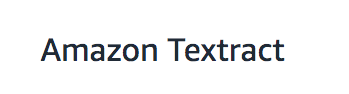

Amazon Textract


In [13]:
# Document
documentName = "OneLine.png"
display(Image(filename=documentName))
# Read document content
with open(documentName, 'rb') as document:
    imageBytes = bytearray(document.read())

# Call Amazon Textract
response = textract.detect_document_text(Document={'Bytes': imageBytes})

# Print detected text
for item in response["Blocks"]:
    if item["BlockType"] == "LINE":
        print (item["Text"])

In [14]:
print("JSON Response\n===================")
display(response)

JSON Response


{'DocumentMetadata': {'Pages': 1},
 'Blocks': [{'BlockType': 'PAGE',
   'Geometry': {'BoundingBox': {'Width': 0.9985673427581787,
     'Height': 1.0,
     'Left': 0.0,
     'Top': 0.0},
    'Polygon': [{'X': 0.0, 'Y': 0.0},
     {'X': 0.9985673427581787, 'Y': 4.546826803444577e-16},
     {'X': 0.9985673427581787, 'Y': 1.0},
     {'X': 0.0, 'Y': 1.0}]},
   'Id': 'c1be2066-bc0e-4695-8e93-a73a73f15bb5',
   'Relationships': [{'Type': 'CHILD',
     'Ids': ['21dc48e8-8be2-4f39-b171-e54728a9ee2c']}]},
  {'BlockType': 'LINE',
   'Confidence': 99.81717681884766,
   'Text': 'Amazon Textract',
   'Geometry': {'BoundingBox': {'Width': 0.7116634845733643,
     'Height': 0.28216034173965454,
     'Left': 0.11438673734664917,
     'Top': 0.39771896600723267},
    'Polygon': [{'X': 0.11438673734664917, 'Y': 0.39771896600723267},
     {'X': 0.8260502219200134, 'Y': 0.39771896600723267},
     {'X': 0.8260502219200134, 'Y': 0.6798793077468872},
     {'X': 0.11438673734664917, 'Y': 0.6798793077468872}]},


# 3. Reading order

In [15]:
# Document
documentName = "textract-samples/two-column-image.jpg"

In [16]:
display(Image(url=s3.generate_presigned_url('get_object', Params={'Bucket': s3BucketName, 'Key': documentName})))

In [17]:
# Call Amazon Textract
response = textract.detect_document_text(
    Document={
        'S3Object': {
            'Bucket': s3BucketName,
            'Name': documentName
        }
    })

#print(response)

# Detect columns and print lines
columns = []
lines = []
for item in response["Blocks"]:
      if item["BlockType"] == "LINE":
        column_found=False
        for index, column in enumerate(columns):
            bbox_left = item["Geometry"]["BoundingBox"]["Left"]
            bbox_right = item["Geometry"]["BoundingBox"]["Left"] + item["Geometry"]["BoundingBox"]["Width"]
            bbox_centre = item["Geometry"]["BoundingBox"]["Left"] + item["Geometry"]["BoundingBox"]["Width"]/2
            column_centre = column['left'] + column['right']/2

            if (bbox_centre > column['left'] and bbox_centre < column['right']) or (column_centre > bbox_left and column_centre < bbox_right):
                #Bbox appears inside the column
                lines.append([index, item["Text"]])
                column_found=True
                break
        if not column_found:
            columns.append({'left':item["Geometry"]["BoundingBox"]["Left"], 'right':item["Geometry"]["BoundingBox"]["Left"] + item["Geometry"]["BoundingBox"]["Width"]})
            lines.append([len(columns)-1, item["Text"]])

lines.sort(key=lambda x: x[0])
for line in lines:
    print (line[1])

Extract data quickly &
accurately
Textract makes it easy to quickly and
accurately extract data from
documents and forms. Textract
automatically detects a document's
layout and the key elements on the
page, understands the data
relationships in any embedded forms
or tables, and extracts everything
with its context intact. This means
you can instantly use the extracted
data in an application or store it in a
database without a lot of
complicated code in between
No code or templates to
maintain
Textract's pre-trained machine
learning models eliminate the need
to write code for data extraction,
because they have already been
trained on tens of millions of
documents from virtually every
industry, including invoices, receipts,
contracts, tax documents, sales
orders, enrollment forms, benefit
applications, insurance claims, policy
documents and many more. You no
longer need to maintain code for
every document or form you might
receive or worry about how page
layouts change over time.


# 4. Natural Language Processing

In [18]:
# Document
documentName = "textract-samples/simple-document-image.jpg"

In [19]:
display(Image(url=s3.generate_presigned_url('get_object', Params={'Bucket': s3BucketName, 'Key': documentName})))

In [20]:
# Call Amazon Textract
response = textract.detect_document_text(
    Document={
        'S3Object': {
            'Bucket': s3BucketName,
            'Name': documentName
        }
    })

#print(response)

# Print text
print("\nText\n========")
text = ""
for item in response["Blocks"]:
    if item["BlockType"] == "LINE":
        print ('\033[94m' +  item["Text"] + '\033[0m')
        text = text + " " + item["Text"]

# Amazon Comprehend client
comprehend = boto3.client('comprehend')

# Detect sentiment
sentiment =  comprehend.detect_sentiment(LanguageCode="en", Text=text)
print ("\nSentiment\n========\n{}".format(sentiment.get('Sentiment')))

# Detect entities
entities =  comprehend.detect_entities(LanguageCode="en", Text=text)
print("\nEntities\n========")
for entity in entities["Entities"]:
    print ("{}\t=>\t{}".format(entity["Type"], entity["Text"]))


Text
Amazon.com, Inc. is located in Seattle, WA
It was founded July 5th, 1994 by Jeff Bezos
Amazon.com allows customers to buy everything from books to blenders
Seattle is north of Portland and south of Vancouver, BC.

Sentiment
NEUTRAL

Entities
ORGANIZATION	=>	Amazon.com, Inc.
LOCATION	=>	Seattle, WA
DATE	=>	July 5th, 1994
PERSON	=>	Jeff Bezos
ORGANIZATION	=>	Amazon.com
LOCATION	=>	Seattle
LOCATION	=>	Portland
LOCATION	=>	Vancouver, BC


# 5. Comprehend Medical

In [21]:
# Document
documentName = "textract-samples/medical-notes.png"

In [22]:
display(Image(url=s3.generate_presigned_url('get_object', Params={'Bucket': s3BucketName, 'Key': documentName})))

In [23]:
# Call Amazon Textract
response = textract.detect_document_text(
    Document={
        'S3Object': {
            'Bucket': s3BucketName,
            'Name': documentName
        }
    })

#print(response)

# Print text
print("\nText\n========")
text = ""
for item in response["Blocks"]:
    if item["BlockType"] == "LINE":
        print ('\033[94m' +  item["Text"] + '\033[0m')
        text = text + " " + item["Text"]

# Amazon Comprehend client
comprehend = boto3.client('comprehendmedical')

# Detect medical entities
entities =  comprehend.detect_entities(Text=text)
print("\nMedical Entities\n========")
for entity in entities["Entities"]:
    print("- {}".format(entity["Text"]))
    print ("   Type: {}".format(entity["Type"]))
    print ("   Category: {}".format(entity["Category"]))
    if(entity["Traits"]):
        print("   Traits:")
        for trait in entity["Traits"]:
            print ("    - {}".format(trait["Name"]))
    print("\n")
    


Text
Patient visit notes
Pt is 40yo mother, high school teacher
HPI : Sleeping trouble on present dosage of Clonidine.
Severe Rash on face and leg, slightly itchy
Meds : Vyvanse 50 mgs po at breakfast daily,
Clonidine 0.2 mgs -- 1 and 1 / 2 tabs po ghs
HEENT : Boggy inferior turbinates, No oropharyngeal lesion
Lungs : clear
Heart : Regular rhythm
Skin : Mild erythematous eruption to hairline
Follow-up as scheduled

Medical Entities
- 40yo
   Type: AGE
   Category: PROTECTED_HEALTH_INFORMATION


- Sleeping trouble
   Type: DX_NAME
   Category: MEDICAL_CONDITION
   Traits:
    - SYMPTOM


- Clonidine
   Type: GENERIC_NAME
   Category: MEDICATION


- Rash
   Type: DX_NAME
   Category: MEDICAL_CONDITION
   Traits:
    - SYMPTOM


- face
   Type: SYSTEM_ORGAN_SITE
   Category: ANATOMY


- leg
   Type: SYSTEM_ORGAN_SITE
   Category: ANATOMY


- Vyvanse
   Type: BRAND_NAME
   Category: MEDICATION


- Clonidine
   Type: GENERIC_NAME
   Category: MEDICATION


- HEENT
   Type: SYSTEM_ORGAN_SITE

# 6. Translate

In [24]:
# Document
documentName = "textract-samples/simple-document-image.jpg"

In [25]:
display(Image(url=s3.generate_presigned_url('get_object', Params={'Bucket': s3BucketName, 'Key': documentName})))

In [26]:
# Call Amazon Textract
response = textract.detect_document_text(
    Document={
        'S3Object': {
            'Bucket': s3BucketName,
            'Name': documentName
        }
    })

#print(response)

# Amazon Translate client
translate = boto3.client('translate')

print ('')
for item in response["Blocks"]:
    if item["BlockType"] == "LINE":
        print ('\033[94m' +  item["Text"] + '\033[0m')
        result = translate.translate_text(Text=item["Text"], SourceLanguageCode="en", TargetLanguageCode="de")
        print ('\033[92m' + result.get('TranslatedText') + '\033[0m')
    print ('')



Amazon.com, Inc. is located in Seattle, WA
Amazon.com, Inc. befindet sich in Seattle, WA

It was founded July 5th, 1994 by Jeff Bezos
Es wurde am 5. Juli 1994 von Jeff Bezos gegründet

Amazon.com allows customers to buy everything from books to blenders
Mit Amazon.com können Kunden alles kaufen, von Büchern bis hin zu Mixern

Seattle is north of Portland and south of Vancouver, BC.
Seattle ist nördlich von Portland und südlich von Vancouver, BC.







































# 7. Search

See code sample at link below:

https://github.com/aws-samples/amazon-textract-code-samples/blob/master/python/07-search.py

# 8. Forms: Key/Values

https://docs.aws.amazon.com/textract/latest/dg/API_AnalyzeDocument.html

In [27]:
# Document
documentName = "textract-samples/employmentapp.png"

In [28]:
display(Image(url=s3.generate_presigned_url('get_object', Params={'Bucket': s3BucketName, 'Key': documentName})))

In [29]:
# Call Amazon Textract
response = textract.analyze_document(
    Document={
        'S3Object': {
            'Bucket': s3BucketName,
            'Name': documentName
        }
    },
    FeatureTypes=["FORMS"])

#print(response)

doc = Document(response)

for page in doc.pages:
    # Print fields
    print("Fields:")
    for field in page.form.fields:
        print("Key: {}, Value: {}".format(field.key, field.value))

    # Get field by key
    print("\nGet Field by Key:")
    key = "Phone Number:"
    field = page.form.getFieldByKey(key)
    if(field):
        print("Key: {}, Value: {}".format(field.key, field.value))

    # Search fields by key
    print("\nSearch Fields:")
    key = "address"
    fields = page.form.searchFieldsByKey(key)
    for field in fields:
        print("Key: {}, Value: {}".format(field.key, field.value))

Fields:
Key: Home Address:, Value: 123 Any Street, Any Town, USA
Key: Mailing Address:, Value: same as home address
Key: Phone Number:, Value: 555-0100
Key: Full Name:, Value: Jane Doe

Get Field by Key:
Key: Phone Number:, Value: 555-0100

Search Fields:
Key: Home Address:, Value: 123 Any Street, Any Town, USA
Key: Mailing Address:, Value: same as home address


## Form Data (Key-Value Pairs) JSON Structure

https://docs.aws.amazon.com/textract/latest/dg/how-it-works-kvp.html

https://docs.aws.amazon.com/textract/latest/dg/how-it-works-selectables.html


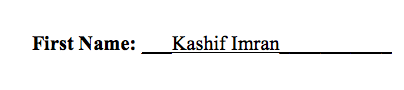

Fields:
Key: First Name:, Value: Kashif Imran


In [30]:
# Document
documentName = "OneKeyValue.png"
display(Image(filename=documentName))
# Read document content
with open(documentName, 'rb') as document:
    imageBytes = bytearray(document.read())

# Call Amazon Textract
response = textract.analyze_document(Document={'Bytes': imageBytes}, FeatureTypes=["FORMS"])

doc = Document(response)

for page in doc.pages:
    # Print fields
    print("Fields:")
    for field in page.form.fields:
        print("Key: {}, Value: {}".format(field.key, field.value))

In [31]:
print("JSON Response\n===================")
display(response)

JSON Response


{'DocumentMetadata': {'Pages': 1},
 'Blocks': [{'BlockType': 'PAGE',
   'Geometry': {'BoundingBox': {'Width': 1.0,
     'Height': 1.0,
     'Left': 0.0,
     'Top': 0.0},
    'Polygon': [{'X': 2.7281736782256487e-17, 'Y': 0.0},
     {'X': 1.0, 'Y': 5.497303649382309e-16},
     {'X': 1.0, 'Y': 1.0},
     {'X': 0.0, 'Y': 1.0}]},
   'Id': 'c46300d5-2cf2-464b-8322-3a3c6308ba26',
   'Relationships': [{'Type': 'CHILD',
     'Ids': ['1d7ad2b2-9fd7-472a-922a-c3fc330de410',
      '6ce12c35-5844-44da-9b2d-ad2f816ead07',
      'a13a94bb-0299-443b-83ae-2640d6638e46',
      'ec80a7ec-0e19-4fc6-b439-72ff811d8793']}]},
  {'BlockType': 'LINE',
   'Confidence': 99.86605072021484,
   'Text': 'First Name:',
   'Geometry': {'BoundingBox': {'Width': 0.2617547810077667,
     'Height': 0.19944661855697632,
     'Left': 0.07699709385633469,
     'Top': 0.38779181241989136},
    'Polygon': [{'X': 0.07699709385633469, 'Y': 0.38779181241989136},
     {'X': 0.338751882314682, 'Y': 0.38779181241989136},
     {'X':

https://github.com/aws-samples/amazon-textract-response-parser

https://github.com/aws-samples/amazon-textract-response-parser/blob/master/src-python/trp.py

# 9. Control and Compliance - Redaction

In [32]:
# Document
documentName = "employmentapp.png"

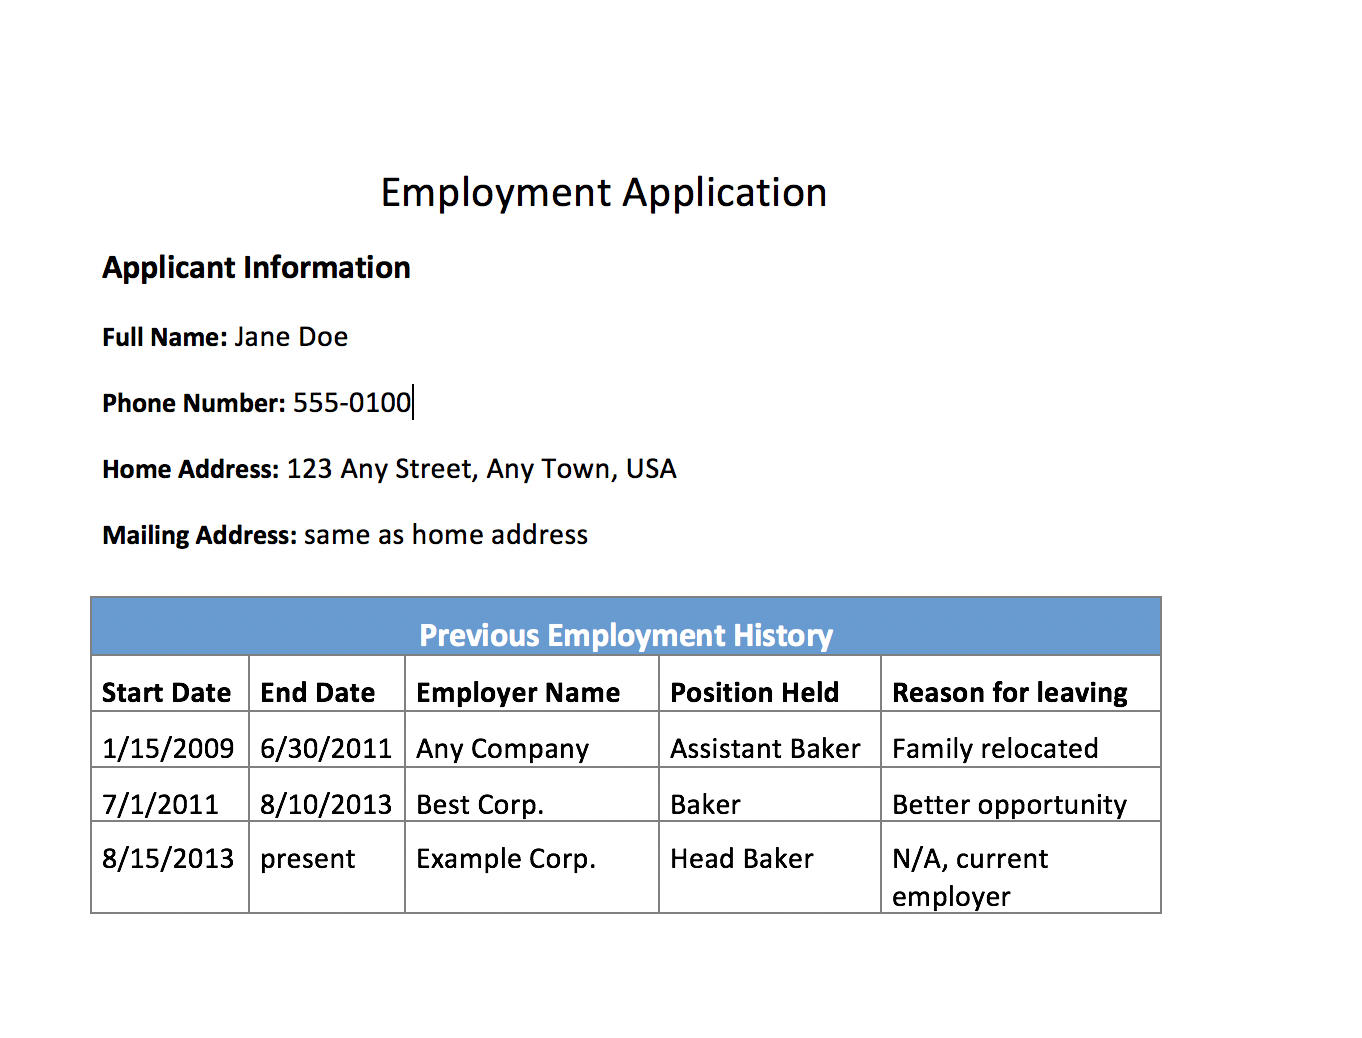

In [33]:
display(Image(filename=documentName))

Redacting => Key: Home Address:, Value: 123 Any Street, Any Town, USA
Redacting => Key: Mailing Address:, Value: same as home address


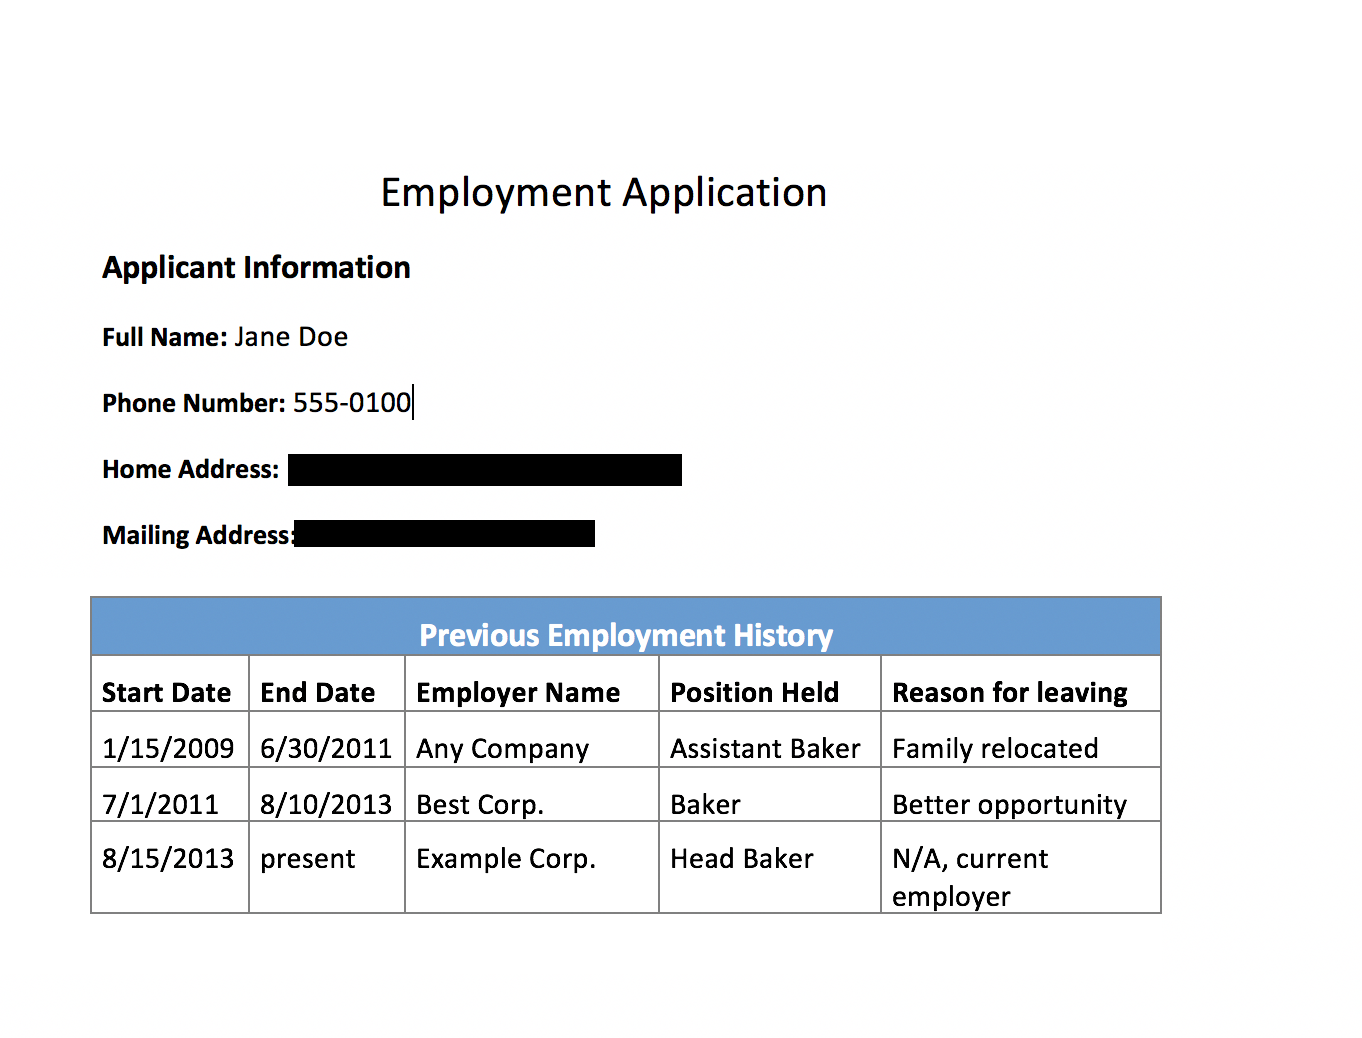

In [34]:
# Call Amazon Textract
with open(documentName, 'rb') as document:
    imageBytes = bytearray(document.read())

# Call Amazon Textract
response = textract.analyze_document(Document={'Bytes': imageBytes}, FeatureTypes=["FORMS"])

#print(response)

doc = Document(response)

# Redact document
img = PImage.open(documentName)

width, height = img.size

if(doc.pages):
    page = doc.pages[0]
    for field in page.form.fields:
        if(field.key and field.value and "address" in field.key.text.lower()):
            print("Redacting => Key: {}, Value: {}".format(field.key.text, field.value.text))
            
            x1 = field.value.geometry.boundingBox.left*width
            y1 = field.value.geometry.boundingBox.top*height-2
            x2 = x1 + (field.value.geometry.boundingBox.width*width)+5
            y2 = y1 + (field.value.geometry.boundingBox.height*height)+2

            draw = ImageDraw.Draw(img)
            draw.rectangle([x1, y1, x2, y2], fill="Black")

outputDocumentName = "redacted-{}".format(documentName)
img.save(outputDocumentName)
display(Image(filename=outputDocumentName))

# 10. Tables

In [35]:
# Document
documentName = "textract-samples/employmentapp.png"

In [36]:
display(Image(url=s3.generate_presigned_url('get_object', Params={'Bucket': s3BucketName, 'Key': documentName})))

In [37]:
# Call Amazon Textract
response = textract.analyze_document(
    Document={
        'S3Object': {
            'Bucket': s3BucketName,
            'Name': documentName
        }
    },
    FeatureTypes=["TABLES"])

#print(response)

doc = Document(response)

for page in doc.pages:
     # Print tables
    for table in page.tables:
        for r, row in enumerate(table.rows):
            for c, cell in enumerate(row.cells):
                print("Table[{}][{}] = {}".format(r, c, cell.text))

Table[0][0] = Start Date 
Table[0][1] = End Date 
Table[0][2] = Employer Name 
Table[0][3] = Position Held 
Table[0][4] = Reason for leaving 
Table[1][0] = 1/15/2009 
Table[1][1] = 6/30/2011 
Table[1][2] = Any Company 
Table[1][3] = Assistant Baker 
Table[1][4] = Family relocated 
Table[2][0] = 7/1/2011 
Table[2][1] = 8/10/2013 
Table[2][2] = Best Corp. 
Table[2][3] = Baker 
Table[2][4] = Better opportunity 
Table[3][0] = 8/15/2013 
Table[3][1] = present 
Table[3][2] = Example Corp. 
Table[3][3] = Head Baker 
Table[3][4] = N/A, current employer 


# Table JSON Structure

https://docs.aws.amazon.com/textract/latest/dg/how-it-works-tables.html

# 11. Table Data Validation

In [38]:
# Document
documentName = "textract-samples/expense.png"

In [39]:
display(Image(url=s3.generate_presigned_url('get_object', Params={'Bucket': s3BucketName, 'Key': documentName})))

In [40]:
# Call Amazon Textract
response = textract.analyze_document(
    Document={
        'S3Object': {
            'Bucket': s3BucketName,
            'Name': documentName
        }
    },
    FeatureTypes=["TABLES"])

#print(response)

doc = Document(response)

def isFloat(input):
  try:
    float(input)
  except ValueError:
    return False
  return True

warning = ""
for page in doc.pages:
     # Print tables
    for table in page.tables:
        for r, row in enumerate(table.rows):
            itemName  = ""
            for c, cell in enumerate(row.cells):
                print("Table[{}][{}] = {}".format(r, c, cell.text))
                if(c == 0):
                    itemName = cell.text
                elif(c == 4 and isFloat(cell.text)):
                    value = float(cell.text)
                    if(value > 1000):
                        warning += "{} is greater than $1000.".format(itemName)
if(warning):
    print("\nReview needed:\n====================\n" + warning)

Table[0][0] = 
Table[0][1] = 
Table[0][2] = Expense Report 
Table[0][3] = 
Table[0][4] = 
Table[1][0] = Expense Description 
Table[1][1] = Type 
Table[1][2] = Date 
Table[1][3] = Merchant Name 
Table[1][4] = Amount (USD) 
Table[2][0] = Furniture (Desks and Chairs) 
Table[2][1] = Office Supplies 
Table[2][2] = 5/10/1019 
Table[2][3] = Merchant One 
Table[2][4] = 1500.00 
Table[3][0] = Team Lunch 
Table[3][1] = Food 
Table[3][2] = 5/11/2019 
Table[3][3] = Merchant Two 
Table[3][4] = 100.00 
Table[4][0] = Team Dinner 
Table[4][1] = Food 
Table[4][2] = 5/12/2019 
Table[4][3] = Merchant Three 
Table[4][4] = 300.00 
Table[5][0] = Laptop 
Table[5][1] = Office Supplies 
Table[5][2] = 5/13/2019 
Table[5][3] = Merchant Three 
Table[5][4] = 200.00 
Table[6][0] = 
Table[6][1] = 
Table[6][2] = 
Table[6][3] = 
Table[6][4] = 
Table[7][0] = 
Table[7][1] = 
Table[7][2] = 
Table[7][3] = 
Table[7][4] = 
Table[8][0] = 
Table[8][1] = 
Table[8][2] = 
Table[8][3] = 
Table[8][4] = 
Table[9][0] = 
Table[9][1] 

# 12. PDF Processing

https://docs.aws.amazon.com/textract/latest/dg/API_StartDocumentTextDetection.html
https://docs.aws.amazon.com/textract/latest/dg/API_GetDocumentTextDetection.html
https://docs.aws.amazon.com/textract/latest/dg/API_StartDocumentAnalysis.html
https://docs.aws.amazon.com/textract/latest/dg/API_GetDocumentAnalysis.html

In [41]:
def startJob(s3BucketName, objectName):
    response = None
    response = textract.start_document_text_detection(
    DocumentLocation={
        'S3Object': {
            'Bucket': s3BucketName,
            'Name': objectName
        }
    })

    return response["JobId"]

def isJobComplete(jobId):
    response = textract.get_document_text_detection(JobId=jobId)
    status = response["JobStatus"]
    print("Job status: {}".format(status))

    while(status == "IN_PROGRESS"):
        time.sleep(5)
        response = textract.get_document_text_detection(JobId=jobId)
        status = response["JobStatus"]
        print("Job status: {}".format(status))

    return status

def getJobResults(jobId):

    pages = []
    response = textract.get_document_text_detection(JobId=jobId)
    
    pages.append(response)
    print("Resultset page recieved: {}".format(len(pages)))
    nextToken = None
    if('NextToken' in response):
        nextToken = response['NextToken']

    while(nextToken):
        response = textract.get_document_text_detection(JobId=jobId, NextToken=nextToken)

        pages.append(response)
        print("Resultset page recieved: {}".format(len(pages)))
        nextToken = None
        if('NextToken' in response):
            nextToken = response['NextToken']

    return pages

In [42]:
# Document
documentName = "textract-samples/Amazon-Textract-Pdf.pdf"

In [43]:
IFrame(s3.generate_presigned_url('get_object', Params={'Bucket': s3BucketName, 'Key': documentName}), 900, 400)

In [45]:
jobId = startJob(s3BucketName, documentName)
print("Started job with id: {}".format(jobId))
if(isJobComplete(jobId)):
    response = getJobResults(jobId)

#print(response)

# Print detected text
for resultPage in response:
    for item in resultPage["Blocks"]:
        if item["BlockType"] == "LINE":
            print ('\033[94m' +  item["Text"] + '\033[0m')

Started job with id: b81e8442b42cc021fbfcbdac063495adf8e0deec6ccaef4203ea14effb9e7c24
Job status: IN_PROGRESS
Job status: IN_PROGRESS
Job status: SUCCEEDED
Resultset page recieved: 1
Amazon Textract
Amazon Textract is a service that automatically extracts text and data from scanned
documents. Amazon Textract goes beyond simple optical character recognition (OCR) to
also identify the contents of fields in forms and information stored in tables.
Many companies today extract data from documents and forms through manual data
entry that's slow and expensive or through simple optical character recognition (OCR)
software that is difficult to customize. Rules and workflows for each document and form
often need to be hard-coded and updated with each change to the form or when dealing
with multiple forms. If the form deviates from the rules, the output is often scrambled
and unusable.
Amazon Textract overcomes these challenges by using machine learning to instantly
"read" virtually any type of d

# 12. Invoices and Receipts processing

In [46]:
# Document
documentName = "textract-samples/expense.png"

In [47]:
display(Image(url=s3.generate_presigned_url('get_object', Params={'Bucket': s3BucketName, 'Key': documentName})))

In [48]:
# Call Amazon Textract
response = textract.analyze_expense(
    Document={
        'S3Object': {
            'Bucket': s3BucketName,
            'Name': documentName
        }
    })

In [49]:

summary_entities_values = []
summary_fields = []
expense_item = []

for expense_doc in response["ExpenseDocuments"]:
    for field in expense_doc["SummaryFields"]:
        kvs = {}
        if "LabelDetection" in field:
            if "ValueDetection" in field:
                kvs[field["LabelDetection"]["Text"]] = field["ValueDetection"]["Text"]
        else:
            kvs[field["Type"]["Text"]] = field["ValueDetection"]["Text"]
        summary_entities_values.append(kvs.copy())
        kvs = None

    for line_item_group in expense_doc["LineItemGroups"]:
            for line_items in line_item_group["LineItems"]:
                for field in line_items["LineItemExpenseFields"]:
                    kvs = {}
                    if "LabelDetection" in field:
                        if "ValueDetection" in field:
                            kvs[field["LabelDetection"]["Text"]] = field["ValueDetection"]["Text"]
                    else:
                        kvs[field["Type"]["Text"]] = field["ValueDetection"]["Text"]
                    expense_item.append(kvs.copy())
                    kvs = None
print("Summary Items:\n")
print(*summary_entities_values, sep='\n')
print("\nExpense Items:\n")
print(*expense_item, sep='\n')

Summary Items:

{'VENDOR_NAME': 'Merchant One'}
{'Merchant Name': 'Merchant One'}
{'Total': '2100.00'}
{'REPORT NUMBER:': '35678-9'}

Expense Items:

{'Expense Description': 'Furniture (Desks and\nChairs)'}
{'Type': 'Office Supplies'}
{'Date': '5/10/1019'}
{'Merchant Name': 'Merchant One'}
{'Amount (USD)': '1500.00'}
{'EXPENSE_ROW': 'Furniture (Desks and\nChairs) Office Supplies 5/10/1019 Merchant One 1500.00'}
{'Expense Description': 'Team Lunch'}
{'Type': 'Food'}
{'Date': '5/11/2019'}
{'Merchant Name': 'Merchant Two'}
{'Amount (USD)': '100.00'}
{'EXPENSE_ROW': 'Team Lunch Food 5/11/2019 Merchant Two 100.00'}
{'Expense Description': 'Team Dinner'}
{'Type': 'Food'}
{'Date': '5/12/2019'}
{'Merchant Name': 'Merchant Three'}
{'Amount (USD)': '300.00'}
{'EXPENSE_ROW': 'Team Dinner Food 5/12/2019 Merchant Three 300.00'}
{'Expense Description': 'Laptop'}
{'Type': 'Office Supplies'}
{'Date': '5/13/2019'}
{'Merchant Name': 'Merchant Three'}
{'Amount (USD)': '200.00'}
{'EXPENSE_ROW': 'Laptop Of

# GitHub repo with samples in other languages

In [ ]:
https://github.com/aws-samples/amazon-textract-code-samples